In [1]:
from __future__ import annotations

from mpi4py import MPI
from petsc4py import PETSc

from pathlib import Path

import dolfinx
import ufl

from dolfinx import default_scalar_type, plot
from tqdm import tqdm
import dolfinx.la as _la
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import grad, inner, split
from basix.ufl import blocked_element, element, enriched_element, mixed_element
from dolfinx.fem import Function, functionspace, dirichletbc, Expression, locate_dofs_topological
import dolfinx_mpc
from dolfinx_mpc import MultiPointConstraint
import numpy as np

import pyvista

# Simulation Setup

In [2]:
nex = int(64)
ney = int(32)

PSRI_control = True
plot_control = False

ele_dict = {0 : "tri_P1",
            1 : "tri_P2",
            2 : "tri_P2B3",
            3 : "qua_P1",
            4 : "qua_P2",
            5 : "qua_S2",}

ele_index = 4
ele_type = ele_dict[ele_index]
tol = 250 * np.finfo(default_scalar_type).resolution

if ele_type == "tri_P2B3":
    cell_type = CellType.triangle
    
elif ele_type == "tri_P2":
    cell_type = CellType.triangle

elif ele_type == "tri_P1":
    cell_type = CellType.triangle
    
elif ele_type == "qua_P2":
    cell_type = CellType.quadrilateral
    
elif ele_type == "qua_P1":
    cell_type = CellType.quadrilateral

elif ele_type == "qua_S2":
    cell_type = CellType.quadrilateral

In [3]:
if not PSRI_control:
    results_folder = Path(f"results/nonlinear_Naghdi/non_PSRI/cylinder_periodic/{nex}_{ney}_{ele_type}")
else:
    results_folder = Path(f"results/nonlinear_Naghdi/cylinder_periodic/{nex}_{ney}_{ele_type}")

results_folder.mkdir(exist_ok=True, parents=True)

if plot_control:
    pyvista.start_xvfb()

# Mesh

In [4]:
r = 1.016 
L = 3.048 
E, nu = 2.0685E7, 0.3 
mu = E/(2.0*(1.0 + nu)) 
lmbda = 2.0*mu*nu/(1.0 - 2.0*nu) 
t = 0.03 

mesh = create_rectangle(MPI.COMM_WORLD, np.array([[-np.pi/2, 0], [3*np.pi/2, L]]), 
                        [nex, ney], cell_type)

tdim = mesh.topology.dim
fdim = tdim - 1

cell = mesh.basix_cell()
P1 = element("Lagrange", cell, degree=1)
P2 = element("Lagrange", cell, degree=2)
if ele_index == 5:
    S2 = element("Serendipity", cell, degree=2)
elif ele_index == 2:
    B3 = element("Bubble", cell, degree=3)

## Plot mesh

In [5]:
topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid, show_edges=True)
plotter.show_grid()
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"mesh_rank{mesh.comm.rank}.png")

plotter.close()

Widget(value='<iframe src="http://localhost:36859/index.html?ui=P_0x7f846ef37530_0&reconnect=auto" class="pyvi…

# Initial configuration

In [5]:
x = ufl.SpatialCoordinate(mesh)
phi0_ufl = ufl.as_vector([r * ufl.sin(x[0]), x[1], r * ufl.cos(x[0])])

def unit_normal(phi):
    n = ufl.cross(phi.dx(0), phi.dx(1))
    return n/ufl.sqrt(inner(n, n))

n0_ufl = unit_normal(phi0_ufl)


## Plot initial configuration

In [8]:
P1_d3_FS = functionspace(mesh, blocked_element(P1, shape = (3,)))

n0_P1_expr = Expression(n0_ufl, P1_d3_FS.element.interpolation_points())
n0_P1_func = Function(P1_d3_FS)
n0_P1_func.interpolate(n0_P1_expr)

phi0_P1_expr = Expression(phi0_ufl, P1_d3_FS.element.interpolation_points())
phi0_P1_func = Function(P1_d3_FS)
phi0_P1_func.interpolate(phi0_P1_expr)

topology, cell_types, geometry = plot.vtk_mesh(P1_d3_FS)

geometry_phi0_P1 = phi0_P1_func.x.array.reshape((geometry.shape[0], len(phi0_P1_func)))
geometry_n0_P1 = n0_P1_func.x.array.reshape((geometry.shape[0], len(n0_P1_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)
grid_phi0_P1["n0"] = geometry_n0_P1
glyphs = grid_phi0_P1.glyph(orient="n0", factor=0.1)


plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k")
plotter.add_mesh(glyphs,  show_scalar_bar=True, scalar_bar_args={"vertical": True})
plotter.show_grid()
plotter.show_axes_all()
plotter.enable_parallel_projection()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"initial_shape_rank{mesh.comm.rank}.png")
    
plotter.close()

Widget(value='<iframe src="http://localhost:38469/index.html?ui=P_0x7fc66546fad0_0&reconnect=auto" class="pyvi…

# director

In [6]:
def tangent_1(phi):
    t1 = phi.dx(0)
    t1 = t1/ufl.sqrt(inner(t1, t1))
    return t1

def tangent_2(n, t1):
    t2 = ufl.cross(n, t1)
    t2 = t2/ufl.sqrt(inner(t2, t2))
    return t2

t1_ufl = tangent_1(phi0_ufl)
t2_ufl = tangent_2(n0_ufl, t1_ufl)

# the analytical expression of R0
def rotation_matrix(t1, t2, n):
    R = ufl.as_matrix([[t1[0], t2[0], n[0]], 
                       [t1[1], t2[1], n[1]], 
                       [t1[2], t2[2], n[2]]])
    return R

R0_ufl = rotation_matrix(t1_ufl, t2_ufl, n0_ufl)

# Update the director with two successive elementary rotations
def director(R0, theta):
    Lm3 = ufl.as_vector([ufl.sin(theta[1])*ufl.cos(theta[0]), -ufl.sin(theta[0]), ufl.cos(theta[1])*ufl.cos(theta[0])])
    d = ufl.dot(R0, Lm3)
    return d

## plot director

In [8]:
# create a FEM interpolation of t1, t2, n0 and phi0
t_FS = functionspace(mesh, blocked_element(P1, shape = (3,)))
t1_expr = Expression(t1_ufl, t_FS.element.interpolation_points())
t1_func = Function(t_FS)
t1_func.interpolate(t1_expr)

t2_expr = Expression(t2_ufl, t_FS.element.interpolation_points())
t2_func = Function(t_FS)
t2_func.interpolate(t2_expr)

n0_expr = Expression(n0_ufl, t_FS.element.interpolation_points())
n0_func = Function(t_FS)
n0_func.interpolate(n0_expr)

phi0_P1_expr = Expression(phi0_ufl, t_FS.element.interpolation_points())
phi0_P1 = Function(t_FS)
phi0_P1.interpolate(phi0_P1_expr)

In [9]:
topology, cell_types, geometry = plot.vtk_mesh(t_FS)

geometry_phi0_P1 = phi0_P1.x.array.reshape((geometry.shape[0], len(phi0_P1)))
geometry_t1 = t1_func.x.array.reshape((geometry.shape[0], len(t1_func)))
geometry_t2 = t2_func.x.array.reshape((geometry.shape[0], len(t2_func)))
geometry_n0 = n0_func.x.array.reshape((geometry.shape[0], len(n0_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)

grid_phi0_P1["n0"] = geometry_n0
grid_phi0_P1["t1"] = geometry_t1
grid_phi0_P1["t2"] = geometry_t2

glyphs_n0 = grid_phi0_P1.glyph(orient="n0", factor=0.1)
glyphs_t1 = grid_phi0_P1.glyph(orient="t1", factor=0.1)
glyphs_t2 = grid_phi0_P1.glyph(orient="t2", factor=0.1)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k", line_width= 0.5)
plotter.add_mesh(glyphs_n0, color = 'b', show_scalar_bar=True)
plotter.add_mesh(glyphs_t1, color = 'r', show_scalar_bar=True)
plotter.add_mesh(glyphs_t2, color = 'g', show_scalar_bar=True)
plotter.camera_position = 'xz'
plotter.camera.azimuth = -45
plotter.camera.elevation = 15
plotter.show_axes_all()
plotter.enable_parallel_projection()
plotter.show()

Widget(value='<iframe src="http://localhost:35405/index.html?ui=P_0x7fb021448800_0&reconnect=auto" class="pyvi…

# Shell element

In [7]:
if ele_type == "tri_P2B3":
    P2B3 = enriched_element([P2, B3])
    naghdi_shell_element = mixed_element(
        [blocked_element(P2B3, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "tri_P2":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
        )

elif ele_type == "tri_P1":
    naghdi_shell_element = mixed_element(
        [blocked_element(P1, shape=(3,)), blocked_element(P1, shape=(2,))]
    )
    
elif ele_type == "qua_P2":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "qua_P1":
    naghdi_shell_element = mixed_element(
        [blocked_element(P1, shape=(3,)), blocked_element(P1, shape=(2,))]
    )

elif ele_type == "qua_S2":
    naghdi_shell_element = mixed_element(
        [blocked_element(S2, shape=(3,)), blocked_element(S2, shape=(2,))]
    )
    
naghdi_shell_FS = functionspace(mesh, naghdi_shell_element)

q_func = Function(naghdi_shell_FS) # current configuration
q_trial = ufl.TrialFunction(naghdi_shell_FS)
q_test = ufl.TestFunction(naghdi_shell_FS)

u_func, theta_func = split(q_func) # current displacement and rotation

# Shell model

In [8]:
# current deformation gradient 
F = grad(u_func) + grad(phi0_ufl) 

# current director
d = director(R0_ufl, theta_func)

# initial metric and curvature tensor a0 and b0
a0_ufl = grad(phi0_ufl).T * grad(phi0_ufl)
b0_ufl = 0.5*( grad(phi0_ufl).T * grad(n0_ufl) + grad(n0_ufl).T * grad(phi0_ufl))

def epsilon(F):
    """Membrane strain"""
    return 0.5 * (F.T * F - a0_ufl)


def kappa(F, d):
    """Bending strain"""
    return 0.5 * (F.T * grad(d) + grad(d).T * F) - b0_ufl


def gamma(F, d):
    """Transverse shear strain"""
    return F.T * d

a0_contra_ufl = ufl.inv(a0_ufl)
j0_ufl = ufl.det(a0_ufl)

i,j,l,m = ufl.indices(4)  # noqa: E741
A_contra_ufl = ufl.as_tensor( ( ((2.0*lmbda*mu) / (lmbda + 2.0*mu)) * a0_contra_ufl[i,j]*a0_contra_ufl[l,m]
                + 1.0*mu* (a0_contra_ufl[i,l]*a0_contra_ufl[j,m] + a0_contra_ufl[i,m]*a0_contra_ufl[j,l]) )
                ,[i,j,l,m])

N = ufl.as_tensor(t * A_contra_ufl[i,j,l,m] * epsilon(F)[l,m], [i,j])

M = ufl.as_tensor( (t**3 / 12.0) * A_contra_ufl[i,j,l,m]*kappa(F, d)[l,m], [i,j])

T = ufl.as_tensor( (t * mu *5.0 / 6.0) * a0_contra_ufl[i, j] * gamma(F, d)[j], [i])

psi_m = 0.5*inner(N, epsilon(F))

psi_b = 0.5*inner(M, kappa(F, d))

psi_s = 0.5*inner(T, gamma(F, d))

# Weak form Equation with PSRI

In [9]:
if ele_type == "qua_P1" or ele_type == "tri_P1":
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 1})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    
else:
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})


# Calculate the factor alpha as a function of the mesh size h
h = ufl.CellDiameter(mesh)
alpha_FS = functionspace(mesh, element("DG", cell, 0))
alpha_expr = Expression(t**2 / h**2, alpha_FS.element.interpolation_points())
alpha = Function(alpha_FS)
alpha.interpolate(alpha_expr)

# Full integration part of the total elastic energy
Pi_PSRI = psi_b * ufl.sqrt(j0_ufl) * dx_f 
Pi_PSRI += alpha * psi_m * ufl.sqrt(j0_ufl) * dx_f
Pi_PSRI += alpha * psi_s * ufl.sqrt(j0_ufl) * dx_f

# Reduced integration part of the total elastic energy
Pi_PSRI += (1.0 - alpha) * psi_m * ufl.sqrt(j0_ufl) * dx_r
Pi_PSRI += (1.0 - alpha) * psi_s * ufl.sqrt(j0_ufl) * dx_r

# external work part (zero in this case)
W_ext = 0.0
Pi_PSRI -= W_ext

Residual = ufl.derivative(Pi_PSRI, q_func, q_test)
Jacobian = ufl.derivative(Residual, q_func, q_trial)

# Boundary conditions

## fully clamped boundary condition

In [10]:
def clamped_boundary(x):
    return np.isclose(x[1], 0.0, atol = tol)

clamped_facets = locate_entities_boundary(mesh, fdim, clamped_boundary)

u_FS, _ = naghdi_shell_FS.sub(0).collapse()
theta_FS, _ = naghdi_shell_FS.sub(1).collapse()

# u1, u2, u3 = 0 on the clamped boundary
u_clamped = Function(u_FS) # default value is 0
clamped_dofs_u = locate_dofs_topological((naghdi_shell_FS.sub(0), u_FS), fdim, clamped_facets)
bc_clamped_u = dirichletbc(u_clamped, clamped_dofs_u, naghdi_shell_FS.sub(0))

# theta1, theta2 = 0 on the clamped boundary
theta_clamped = Function(theta_FS) # default value is 0
clamped_dofs_theta = locate_dofs_topological((naghdi_shell_FS.sub(1), theta_FS), fdim, clamped_facets)
bc_clamped_theta = dirichletbc(theta_clamped, clamped_dofs_theta, naghdi_shell_FS.sub(1))

bcs = [bc_clamped_u, bc_clamped_theta]

## Periodic Boundary condition

In [11]:
def periodic_boundary(x):
    return np.isclose(x[0], 3*np.pi/2, atol=tol)


def periodic_relation(x):
    out_x = np.zeros_like(x)
    out_x[0] = x[0] - 2*np.pi
    out_x[1] = x[1]
    out_x[2] = x[2]
    return out_x

mpc = MultiPointConstraint(naghdi_shell_FS)
mpc.create_periodic_constraint_geometrical(naghdi_shell_FS.sub(0).sub(0), periodic_boundary, periodic_relation, bcs)
mpc.create_periodic_constraint_geometrical(naghdi_shell_FS.sub(0).sub(1), periodic_boundary, periodic_relation, bcs)
mpc.create_periodic_constraint_geometrical(naghdi_shell_FS.sub(0).sub(2), periodic_boundary, periodic_relation, bcs)
mpc.create_periodic_constraint_geometrical(naghdi_shell_FS.sub(1).sub(0), periodic_boundary, periodic_relation, bcs)
mpc.create_periodic_constraint_geometrical(naghdi_shell_FS.sub(1).sub(1), periodic_boundary, periodic_relation, bcs)
mpc.finalize()

### Check MPC constraints

In [17]:
# Sanity check that the MPC class has some constraints to impose
num_slaves_global = mesh.comm.allreduce(len(mpc.slaves), op=MPI.SUM)
num_masters_global = mesh.comm.allreduce(len(mpc.masters.array), op=MPI.SUM)

assert num_slaves_global > 0
assert num_masters_global == num_slaves_global

print(f"number of total master dofs: {num_masters_global}")
print(f"number of total slave dofs: {num_slaves_global}")


number of total master dofs: 320
number of total slave dofs: 320


# Locate Point Source

In [12]:
def compute_cell_contributions(V, points):
    # Determine what process owns a point and what cells it lies within
    mesh = V.mesh
    _, _, owning_points, cells = dolfinx.cpp.geometry.determine_point_ownership(
        mesh._cpp_object, points, 1e-6)
    owning_points = np.asarray(owning_points).reshape(-1, 3)

    # Pull owning points back to reference cell
    mesh_nodes = mesh.geometry.x
    cmap = mesh.geometry.cmaps[0]
    ref_x = np.zeros((len(cells), mesh.geometry.dim),
                     dtype=mesh.geometry.x.dtype)
    for i, (point, cell) in enumerate(zip(owning_points, cells)):
        geom_dofs = mesh.geometry.dofmap[cell]
        ref_x[i] = cmap.pull_back(point.reshape(-1, 3), mesh_nodes[geom_dofs])

    # Create expression evaluating a trial function (i.e. just the basis function)
    u = ufl.TrialFunction(V.sub(0).sub(2))
    num_dofs = V.sub(0).sub(2).dofmap.dof_layout.num_dofs * V.sub(0).sub(2).dofmap.bs
    if len(cells) > 0:
        # NOTE: Expression lives on only this communicator rank
        expr = dolfinx.fem.Expression(u, ref_x, comm=MPI.COMM_SELF)
        values = expr.eval(mesh, np.asarray(cells, dtype=np.int32))

        # Strip out basis function values per cell
        basis_values = values[:num_dofs:num_dofs*len(cells)]
    else:
        basis_values = np.zeros(
            (0, num_dofs), dtype=dolfinx.default_scalar_type)
    return cells, basis_values

In [13]:
if mesh.comm.rank == 0:
    points_A = np.array([[0.0, L, 0.0]], dtype=mesh.geometry.x.dtype)
    points_B = np.array([[np.pi, L, 0.0]], dtype=mesh.geometry.x.dtype)
else:
    points_A = np.zeros((0, 3), dtype=mesh.geometry.x.dtype)
    points_B = np.zeros((0, 3), dtype=mesh.geometry.x.dtype)

ps_cells_A, basis_values_A = compute_cell_contributions(naghdi_shell_FS, points_A)
ps_cells_B, basis_values_B = compute_cell_contributions(naghdi_shell_FS, points_B)

## check point source

In [15]:
print(f"cell_A: {ps_cells_A}, basis values of A: {basis_values_A}")
print(f"cell_B: {ps_cells_B}, basis values of B: {basis_values_B}")


cell_A: [976], basis values of A: [[0. 0. 0. 1. 0. 0. 0. 0. 0.]]
cell_B: [1895], basis values of B: [[0. 0. 0. 1. 0. 0. 0. 0. 0.]]


# Nonlinear MPC problem with point source

In [14]:
class NonlinearMPCProblem(dolfinx.fem.petsc.NonlinearProblem):
    def __init__(self, F, u, mpc, bcs=[], J=None,
                 cells_A = [], basis_values_A = [], PS_A: float = 0.0,
                 cells_B = [], basis_values_B = [], PS_B: float = 0.0,
                 form_compiler_options={}, jit_options={}):
        self.mpc = mpc
        super().__init__(F, u, bcs=bcs, J=J, form_compiler_options=form_compiler_options, jit_options=jit_options)
        
        self.PS_A = PS_A
        self.cells_A = cells_A
        self.basis_values_A = basis_values_A
        
        self.PS_B = PS_B
        self.cells_B = cells_B
        self.basis_values_B = basis_values_B
    
    def F(self, x: PETSc.Vec, F: PETSc.Vec):  # type: ignore
        with F.localForm() as F_local:
            F_local.set(0.0)
        dolfinx_mpc.assemble_vector(self._L, self.mpc, b=F)
        
        # Add point source
        if len(self.cells_A) > 0:
            for cell, basis_value in zip(self.cells_A, self.basis_values_A):
                dofs = self.mpc.function_space.sub(0).sub(2).dofmap.cell_dofs(cell)
                with F.localForm() as F_local:
                    F_local.setValuesLocal(dofs, basis_value * -self.PS_A, addv=PETSc.InsertMode.ADD_VALUES)
        
        if len(self.cells_B) > 0:
            for cell, basis_value in zip(self.cells_B, self.basis_values_B):
                dofs = self.mpc.function_space.sub(0).sub(2).dofmap.cell_dofs(cell)
                with F.localForm() as F_local:
                    F_local.setValuesLocal(dofs, basis_value * -self.PS_B, addv=PETSc.InsertMode.ADD_VALUES)
        
        # Apply boundary condition
        dolfinx_mpc.apply_lifting(
            F,
            [self._a],
            bcs=[self.bcs],
            constraint=self.mpc,
            x0=[x],
            scale=dolfinx.default_scalar_type(-1.0),
        )
        F.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)  # type: ignore
        dolfinx.fem.petsc.set_bc(F, self.bcs, x, -1.0)

    def J(self, x: PETSc.Vec, A: PETSc.Mat):  # type: ignore
        A.zeroEntries()
        dolfinx_mpc.assemble_matrix(self._a, self.mpc, bcs=self.bcs, A=A)
        A.assemble()


# Newton solver with MPC

In [15]:
class NewtonSolverMPC(dolfinx.cpp.nls.petsc.NewtonSolver):
    def __init__(
        self,
        comm: MPI.Intracomm,
        problem: NonlinearMPCProblem,
        mpc: dolfinx_mpc.MultiPointConstraint,
    ):
        """A Newton solver for non-linear MPC problems."""
        super().__init__(comm)
        self.mpc = mpc
        self.u_mpc = dolfinx.fem.Function(mpc.function_space)

        # Create matrix and vector to be used for assembly of the non-linear
        # MPC problem
        self._A = dolfinx_mpc.cpp.mpc.create_matrix(problem.a._cpp_object, mpc._cpp_object)
        self._b = _la.create_petsc_vector(mpc.function_space.dofmap.index_map, mpc.function_space.dofmap.index_map_bs)

        self.setF(problem.F, self._b)
        self.setJ(problem.J, self._A)
        self.set_form(problem.form)
        self.set_update(self.update)

    def update(self, solver: dolfinx.nls.petsc.NewtonSolver, dx: PETSc.Vec, x: PETSc.Vec):  # type: ignore
        # We need to use a vector created on the MPC's space to update ghosts
        self.u_mpc.vector.array = x.array_r
        self.u_mpc.vector.axpy(-1.0, dx)
        self.u_mpc.vector.ghostUpdate(
            addv=PETSc.InsertMode.INSERT,  # type: ignore
            mode=PETSc.ScatterMode.FORWARD,  # type: ignore
        )  # type: ignore
        self.mpc.homogenize(self.u_mpc)
        self.mpc.backsubstitution(self.u_mpc)
        x.array = self.u_mpc.vector.array_r
        x.ghostUpdate(
            addv=PETSc.InsertMode.INSERT,  # type: ignore
            mode=PETSc.ScatterMode.FORWARD,  # type: ignore
        )  # type: ignore

    def solve(self, u: dolfinx.fem.Function):
        """Solve non-linear problem into function u. Returns the number
        of iterations and if the solver converged."""
        n, converged = super().solve(u.vector)
        u.x.scatter_forward()
        return n, converged

    @property
    def A(self) -> PETSc.Mat:  # type: ignore
        """Jacobian matrix"""
        return self._A

    @property
    def b(self) -> PETSc.Vec:  # type: ignore
        """Residual vector"""
        return self._b

# Setup of solver

In [16]:
problem = NonlinearMPCProblem(Residual, q_func, mpc, bcs=bcs, J=Jacobian,
                            cells_A = ps_cells_A, basis_values_A = basis_values_A, PS_A=0.0,
                            cells_B = ps_cells_B, basis_values_B = basis_values_B, PS_B=0.0)

solver = NewtonSolverMPC(mesh.comm, problem, mpc)

# Set Newton solver options
solver.rtol = 1e-6
solver.atol = 1e-6
solver.max_it = 200
solver.convergence_criterion = "incremental"
solver.report = True

# Modify the linear solver in each Newton iteration
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
ksp.setFromOptions()

In [24]:
file_u = dolfinx.io.VTKFile(mesh.comm, results_folder/"u.bp", "w")
file_theta = dolfinx.io.VTKFile(mesh.comm, results_folder/"theta.bp", "w")
file_phi = dolfinx.io.VTKFile(mesh.comm, results_folder/"phi.bp", "w")

In [18]:
bb_point_A = np.array([[0.0, L, 0.0]], dtype=np.float64)
bb_point_B = np.array([[np.pi, L, 0.0]], dtype=np.float64)

def point_values():
    WA_bb = None
    WB_bb = None
    
    u3_func = q_func.sub(0).sub(2).collapse()
    
    if len(ps_cells_A) > 0:
        WA_bb = u3_func.eval(bb_point_A, ps_cells_A[0])[0]
    WA_bb = mesh.comm.gather(WA_bb, root=0)
    
    if len(ps_cells_B) > 0:
        WB_bb = u3_func.eval(bb_point_B, ps_cells_B[0])[0]
    WB_bb = mesh.comm.gather(WB_bb, root=0)
    
    return WA_bb, WB_bb

In [25]:
PS_diff = -50.0
n_step = 40

# store the displacement at the point load 
if mesh.comm.rank == 0:
    WA_list = np.zeros(n_step + 1)
    WB_list = np.zeros(n_step + 1)
    
PS_list = np.arange(0, PS_diff * (n_step + 1), PS_diff)  
PS_max = PS_list[-1]
q_func.x.array[:] = 0.0

for i in tqdm(range(0, n_step + 1)):
    problem.PS_A = PS_diff * i
    problem.PS_B = -PS_diff * i
    n, converged = solver.solve(q_func)
    assert (converged)
    q_func.x.scatter_forward()
    if mesh.comm.rank == 0:
        print(f"Load step {i:d}, Number of iterations: {n:d}, Load: {problem.PS_A:.2f}({PS_max})", flush=True)
    
    # output the solution
    phi_FS = functionspace(mesh, blocked_element(P1, shape=(3,)))
    theta_FS = functionspace(mesh, blocked_element(P1, shape=(2,)))
    u_sub = q_func.sub(0).collapse()
    theta_sub = q_func.sub(1).collapse()

    phi_expr = Expression(phi0_ufl + u_sub, phi_FS.element.interpolation_points())
    u_expr = Expression(u_sub, phi_FS.element.interpolation_points())
    theta_expr = Expression(theta_sub, theta_FS.element.interpolation_points())
    
    phi_sol = Function(phi_FS)
    u_sol = Function(phi_FS)
    theta_sol = Function(theta_FS)
    phi_sol.interpolate(phi_expr)
    u_sol.interpolate(u_expr)
    theta_sol.interpolate(theta_expr)
    
    file_u.write_function(u_sol, i)
    file_theta.write_function(theta_sol, i)
    file_phi.write_function(phi_sol, i)
    
    # calculate u3 at the point load
    WA_bb, WB_bb = point_values()
    if mesh.comm.rank == 0:
        for WA in WA_bb:
            if WA is not None:
                WA_list[i] = WA
                break
        
        for WB in WB_bb:
            if WB is not None:
                WB_list[i] = WB
                break


  0%|          | 0/40 [00:00<?, ?it/s]

Load step 1, Number of iterations: 5, Load: -50.00(-2000.0)


  2%|▎         | 1/40 [00:04<02:41,  4.15s/it]

Load step 2, Number of iterations: 6, Load: -100.00(-2000.0)


  5%|▌         | 2/40 [00:08<02:51,  4.52s/it]

Load step 3, Number of iterations: 6, Load: -150.00(-2000.0)


  8%|▊         | 3/40 [00:13<02:48,  4.57s/it]

Load step 4, Number of iterations: 6, Load: -200.00(-2000.0)


 10%|█         | 4/40 [00:18<02:48,  4.68s/it]

Load step 5, Number of iterations: 6, Load: -250.00(-2000.0)


 12%|█▎        | 5/40 [00:23<02:45,  4.74s/it]

Load step 6, Number of iterations: 6, Load: -300.00(-2000.0)


 15%|█▌        | 6/40 [00:30<03:06,  5.49s/it]

Load step 7, Number of iterations: 6, Load: -350.00(-2000.0)


 18%|█▊        | 7/40 [00:37<03:17,  5.97s/it]

Load step 8, Number of iterations: 6, Load: -400.00(-2000.0)


 20%|██        | 8/40 [00:43<03:12,  6.01s/it]

Load step 9, Number of iterations: 6, Load: -450.00(-2000.0)


 22%|██▎       | 9/40 [00:48<02:56,  5.71s/it]

Load step 10, Number of iterations: 7, Load: -500.00(-2000.0)


 25%|██▌       | 10/40 [00:54<02:55,  5.85s/it]

Load step 11, Number of iterations: 8, Load: -550.00(-2000.0)


 28%|██▊       | 11/40 [01:00<02:54,  6.01s/it]

Load step 12, Number of iterations: 10, Load: -600.00(-2000.0)


 30%|███       | 12/40 [01:09<03:09,  6.77s/it]

Load step 13, Number of iterations: 11, Load: -650.00(-2000.0)


 32%|███▎      | 13/40 [01:18<03:19,  7.38s/it]

Load step 14, Number of iterations: 10, Load: -700.00(-2000.0)


 35%|███▌      | 14/40 [01:26<03:22,  7.80s/it]

Load step 15, Number of iterations: 10, Load: -750.00(-2000.0)


 38%|███▊      | 15/40 [01:34<03:17,  7.89s/it]

Load step 16, Number of iterations: 8, Load: -800.00(-2000.0)


 40%|████      | 16/40 [01:41<02:55,  7.33s/it]

Load step 17, Number of iterations: 8, Load: -850.00(-2000.0)


 42%|████▎     | 17/40 [01:47<02:39,  6.95s/it]

Load step 18, Number of iterations: 7, Load: -900.00(-2000.0)


 45%|████▌     | 18/40 [01:53<02:31,  6.89s/it]

Load step 19, Number of iterations: 7, Load: -950.00(-2000.0)


 48%|████▊     | 19/40 [01:59<02:17,  6.53s/it]

Load step 20, Number of iterations: 6, Load: -1000.00(-2000.0)


 50%|█████     | 20/40 [02:05<02:04,  6.25s/it]

Load step 21, Number of iterations: 6, Load: -1050.00(-2000.0)


 52%|█████▎    | 21/40 [02:09<01:49,  5.77s/it]

Load step 22, Number of iterations: 6, Load: -1100.00(-2000.0)


 55%|█████▌    | 22/40 [02:14<01:38,  5.45s/it]

Load step 23, Number of iterations: 6, Load: -1150.00(-2000.0)


 57%|█████▊    | 23/40 [02:20<01:33,  5.51s/it]

Load step 24, Number of iterations: 6, Load: -1200.00(-2000.0)


 60%|██████    | 24/40 [02:25<01:25,  5.35s/it]

Load step 25, Number of iterations: 6, Load: -1250.00(-2000.0)


 62%|██████▎   | 25/40 [02:29<01:17,  5.19s/it]

Load step 26, Number of iterations: 6, Load: -1300.00(-2000.0)


 65%|██████▌   | 26/40 [02:34<01:10,  5.00s/it]

Load step 27, Number of iterations: 6, Load: -1350.00(-2000.0)


 68%|██████▊   | 27/40 [02:39<01:04,  4.94s/it]

Load step 28, Number of iterations: 6, Load: -1400.00(-2000.0)


 70%|███████   | 28/40 [02:43<00:57,  4.78s/it]

Load step 29, Number of iterations: 6, Load: -1450.00(-2000.0)


 72%|███████▎  | 29/40 [02:48<00:51,  4.72s/it]

Load step 30, Number of iterations: 5, Load: -1500.00(-2000.0)


 75%|███████▌  | 30/40 [02:52<00:45,  4.51s/it]

Load step 31, Number of iterations: 5, Load: -1550.00(-2000.0)


 78%|███████▊  | 31/40 [02:56<00:38,  4.31s/it]

Load step 32, Number of iterations: 5, Load: -1600.00(-2000.0)


 80%|████████  | 32/40 [03:00<00:33,  4.23s/it]

Load step 33, Number of iterations: 5, Load: -1650.00(-2000.0)


 82%|████████▎ | 33/40 [03:04<00:30,  4.32s/it]

Load step 34, Number of iterations: 5, Load: -1700.00(-2000.0)


 85%|████████▌ | 34/40 [03:09<00:26,  4.36s/it]

Load step 35, Number of iterations: 5, Load: -1750.00(-2000.0)


 88%|████████▊ | 35/40 [03:13<00:21,  4.25s/it]

Load step 36, Number of iterations: 5, Load: -1800.00(-2000.0)


 90%|█████████ | 36/40 [03:17<00:16,  4.15s/it]

Load step 37, Number of iterations: 6, Load: -1850.00(-2000.0)


 92%|█████████▎| 37/40 [03:21<00:13,  4.36s/it]

Load step 38, Number of iterations: 6, Load: -1900.00(-2000.0)


 95%|█████████▌| 38/40 [03:27<00:09,  4.59s/it]

Load step 39, Number of iterations: 6, Load: -1950.00(-2000.0)


 98%|█████████▊| 39/40 [03:32<00:04,  4.79s/it]

Load step 40, Number of iterations: 6, Load: -2000.00(-2000.0)


100%|██████████| 40/40 [03:37<00:00,  5.43s/it]


In [21]:
topology, cell_types, geometry = plot.vtk_mesh(phi_FS)
geometry_phi = phi_sol.x.array.reshape((geometry.shape[0], len(phi_sol)))
grid_phi = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi, show_edges=True)
plotter.show_grid()
plotter.enable_parallel_projection()
plotter.show_axes_all()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/"phi.png")
plotter.close()

Widget(value='<iframe src="http://localhost:43095/index.html?ui=P_0x7f262c2ef050_0&reconnect=auto" class="pyvi…

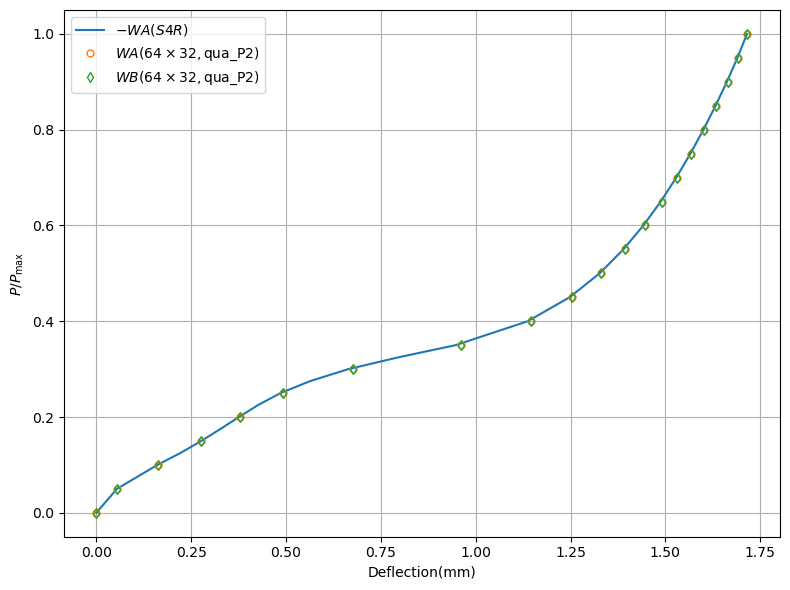

In [23]:
import matplotlib.pyplot as plt

if mesh.comm.rank == 0:
    WA_S4R = 1.e-2*np.array([0., 5.421, 16.1, 22.195, 27.657, 32.7, 37.582, 42.633,
        48.537, 56.355, 66.410, 79.810, 94.669, 113.704, 124.751, 132.653,
        138.920, 144.185, 148.770, 152.863, 156.584, 160.015, 163.211,
        166.200, 168.973, 171.505])
        
    P_S4R = np.array([0., .05, .1, .125, .15, .175, .2, .225, .25, .275, .3,
        .325, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1.])
    
    np.savetxt(results_folder/"PS_Pmax.txt", PS_list/PS_max)
    np.savetxt(results_folder/"WA.txt", WA_list)
    np.savetxt(results_folder/"WB.txt", WB_list)
    
    plt.figure(figsize=(8.0, 6.0))
    plt.plot(WA_S4R, P_S4R, "-", label="$-WA(S4R)$")
    plt.plot(-WA_list, PS_list / PS_max, "o", markersize=5, markerfacecolor='none',
             markevery = 2, label=f"$WA({nex}\\times{ney},${ele_type})")
    plt.plot(WB_list, PS_list / PS_max, "d", markersize=5, markerfacecolor='none',
             markevery = 2, label=f"$WB({nex}\\times{ney},${ele_type})")
    plt.xlabel("Deflection(mm)")
    plt.ylabel(r"$P/P_{\mathrm{max}}$")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(results_folder/"comparisons.png", dpi=300)